In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [2]:
df_train=pd.read_csv("/kaggle/input/quora-question-pairs/train.csv.zip")
df_test=pd.read_csv("/kaggle/input/quora-question-pairs/test.csv")
df_train_copy=df_train.copy()
df_test_copy=df_test.copy()

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_train['question1'].fillna('missing', inplace=True)
df_train['question2'].fillna('missing', inplace=True)
df_test['question1'].fillna('missing', inplace=True)
df_test['question2'].fillna('missing', inplace=True)

In [5]:
df_train=df_train.sample(30000)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def CountVectorizerFeatures(df):
    ques_df=df[['question1','question2']]
    questions = list(ques_df['question1']) + list(ques_df['question2'])
    cv = CountVectorizer(max_features=3000)
    q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)
    temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
    temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
    temp_df = pd.concat([temp_df1, temp_df2], axis=1)
    return temp_df

def TfIdfFeatures(df):
    ques_df=df[['question1','question2']]
    questions = list(ques_df['question1']) + list(ques_df['question2'])
    tfidf = TfidfVectorizer(max_features=3000)
    q1_arr, q2_arr = np.vsplit(tfidf.fit_transform(questions).toarray(),2)
    temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
    temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
    temp_df = pd.concat([temp_df1, temp_df2], axis=1)
    return temp_df



In [6]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classifiers(clf,X_train,y_train,X_test,y_test):
   
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score=accuracy_score(y_test,y_pred)
        matrix=confusion_matrix(y_test,y_pred)
        loss=log_loss(y_pred,y_test)
        return score,loss

In [7]:
print(df_train['question1'].duplicated().sum())
print(df_train['question2'].duplicated().sum())

1577
1584


In [8]:
df_train.columns = df_train.columns.astype(str)
y=df_train['is_duplicate']
temp_df_bow=CountVectorizerFeatures(df_train)
temp_df_idf=TfIdfFeatures(df_train)

In [9]:
X_bow_train,X_bow_test,y_bow_train,y_bow_test=train_test_split(temp_df_bow,y,test_size=0.2)
X_idf_train,X_idf_test,y_idf_train,y_idf_test=train_test_split(temp_df_idf,y,test_size=0.2)

In [10]:
print("Random Forest Results:")
print(evaluate_classifiers(RandomForestClassifier(),X_bow_train,y_bow_train,X_bow_test,y_bow_test))
print(evaluate_classifiers(RandomForestClassifier(),X_idf_train,y_idf_train,X_idf_test,y_idf_test))


Random Forest Results:
(0.7418333333333333, 9.305269849957078)
(0.7418333333333333, 9.305269849957078)


In [11]:
print("Extra Trees Results:")
print(evaluate_classifiers(ExtraTreesClassifier(),X_bow_train,y_bow_train,X_bow_test,y_bow_test))
print(evaluate_classifiers(ExtraTreesClassifier(),X_idf_train,y_idf_train,X_idf_test,y_idf_test))


Extra Trees Results:
(0.7476666666666667, 9.095015205187229)
(0.7548333333333334, 8.836702355898556)


In [12]:

print("Logistic Regression")
print(evaluate_classifiers(LogisticRegression(),X_bow_train,y_bow_train,X_bow_test,y_bow_test))
print(evaluate_classifiers(LogisticRegression(),X_idf_train,y_idf_train,X_idf_test,y_idf_test))


Logistic Regression
(0.7036666666666667, 10.680935954308381)
(0.715, 10.272441215898388)


# Feature Engineering Set-1

In [13]:
from nltk.tokenize import word_tokenize,sent_tokenize
def fs_1(df):
    df['question1']=df['question1'].str.lower()
    df['question2']=df['question2'].str.lower()
    df['q1_len']=df['question1'].str.len()
    df['q2_len']=df['question2'].str.len()
    df['w1_tokens'] = df['question1'].apply(word_tokenize)
    df['w2_tokens'] = df['question2'].apply(word_tokenize)
    df['w1_tot'] = df['w1_tokens'].apply(len)
    df['w2_tot'] = df['w2_tokens'].apply(len)
    df['common_words'] = df.apply(lambda row: len(set(row['w1_tokens']).intersection(set(row['w2_tokens']))), axis=1)
    df['word_share']=(df['common_words']/(df['w1_tot']+df['w2_tot']))*100
    return df   

In [14]:
df_train=fs_1(df_train)

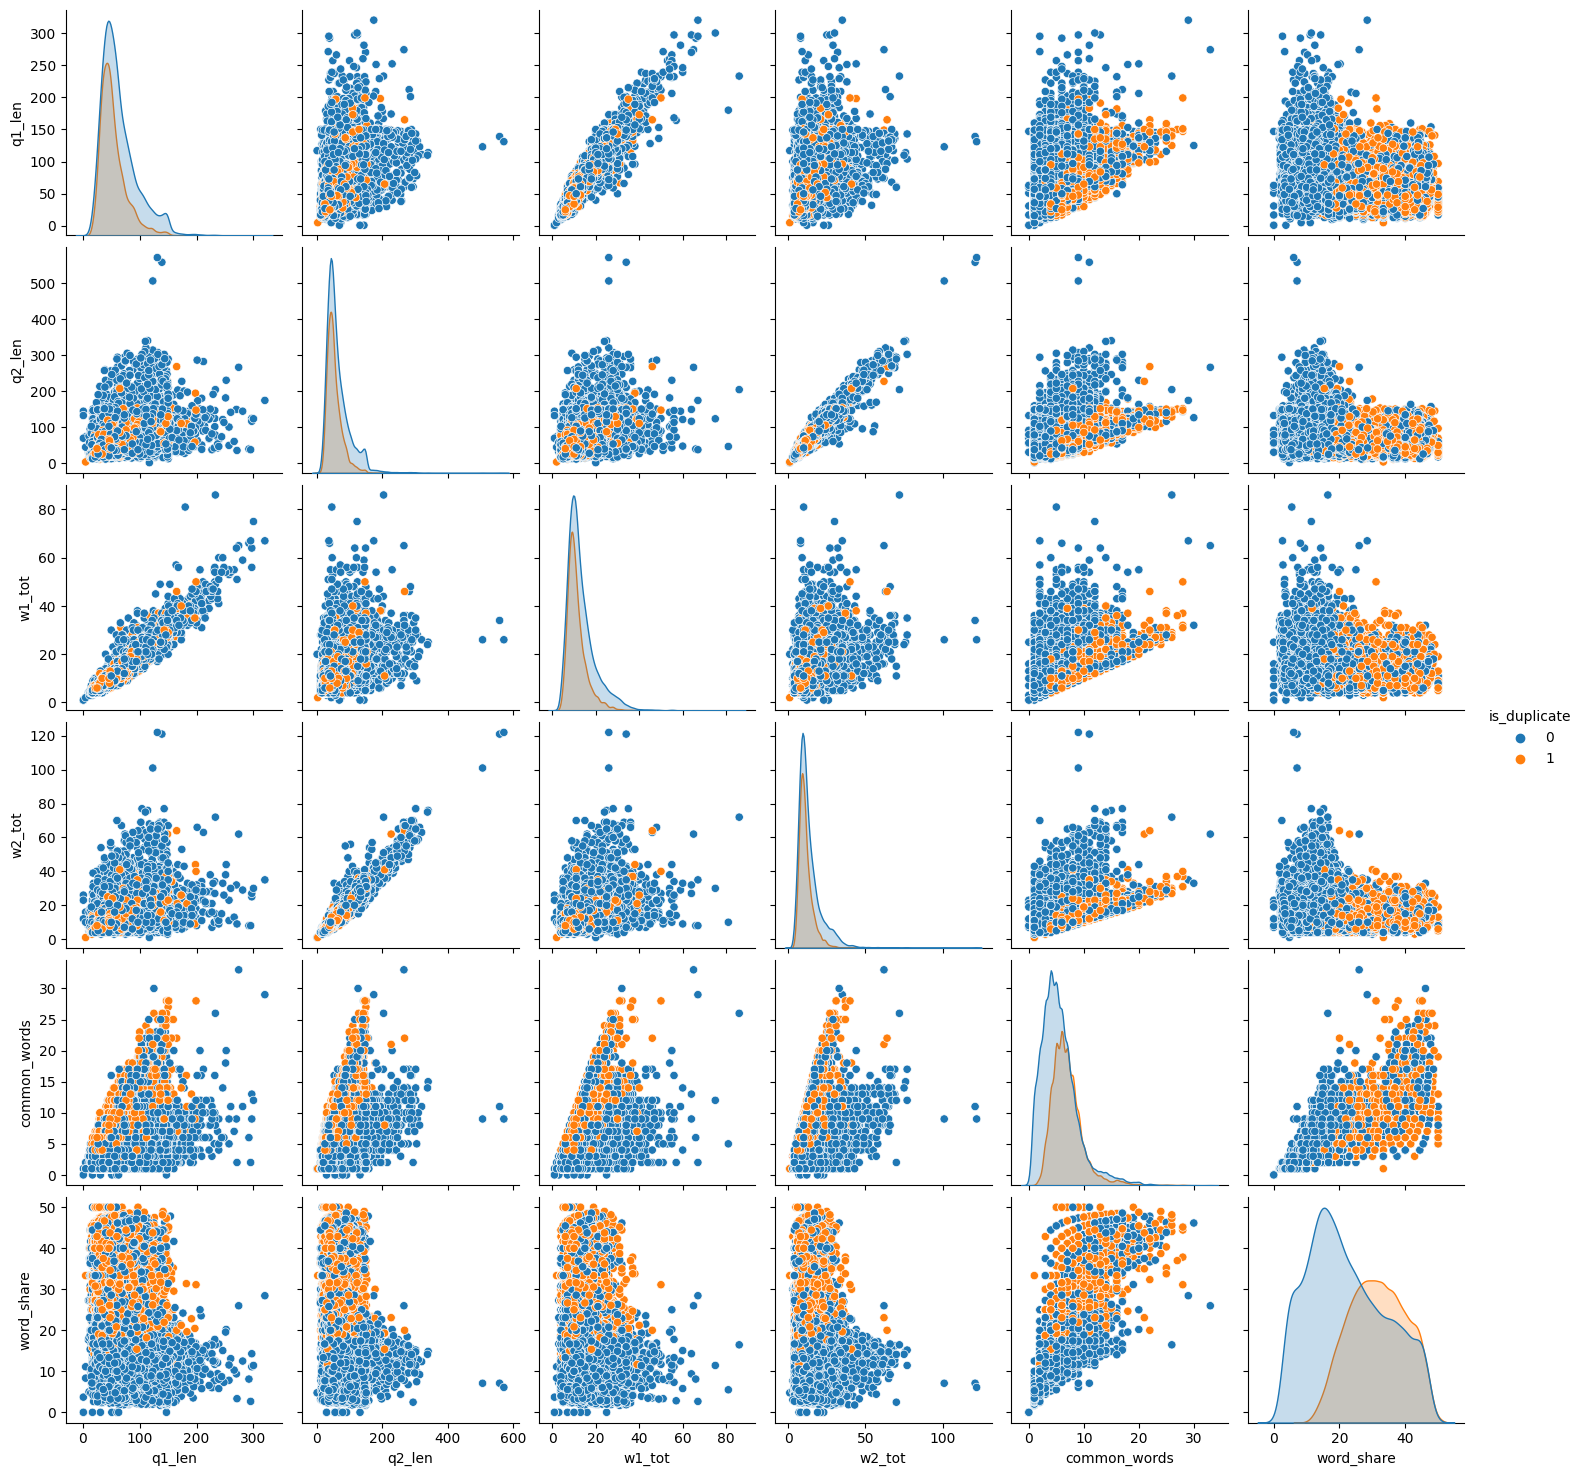

In [15]:
columns_fs1=['q1_len','q2_len','w1_tot','w2_tot','common_words','word_share','is_duplicate']
sns.pairplot(data=df_train[columns_fs1],hue='is_duplicate')

In [16]:
df_train[columns_fs1].corr()

,q1_len,q2_len,w1_tot,w2_tot,common_words,word_share,is_duplicate
q1_len,1.000000,0.487969,0.949407,0.458437,0.354955,-0.279911,-0.170442
q2_len,0.487969,1.000000,0.453257,0.959659,0.361237,-0.267182,-0.161780
w1_tot,0.949407,0.453257,1.000000,0.467717,0.361050,-0.285043,-0.162127
w2_tot,0.458437,0.959659,0.467717,1.000000,0.356605,-0.282240,-0.167215
common_words,0.354955,0.361237,0.361050,0.356605,1.000000,0.644885,0.204799
word_share,-0.279911,-0.267182,-0.285043,-0.282240,0.644885,1.000000,0.385230
is_duplicate,-0.170442,-0.161780,-0.162127,-0.167215,0.204799,0.385230,1.000000


In [17]:
df_train.columns = df_train.columns.astype(str)
columns_fs1=['q1_len','q2_len','w1_tot','w2_tot','common_words','word_share']
temp_df_bow=pd.concat([temp_df_bow,df_train[columns_fs1]],axis=1)
temp_df_idf=pd.concat([temp_df_idf,df_train[columns_fs1]],axis=1)
X_bow_train,X_bow_test,y_bow_train,y_bow_test=train_test_split(temp_df_bow,y,test_size=0.2)
X_idf_train,X_idf_test,y_idf_train,y_idf_test=train_test_split(temp_df_idf,y,test_size=0.2)
X_bow_train.columns = X_bow_train.columns.astype(str)
X_bow_test.columns = X_bow_test.columns.astype(str)
X_idf_train.columns = X_bow_train.columns.astype(str)
X_idf_test.columns = X_bow_test.columns.astype(str)



In [18]:

print("Extra Trees Results with fs1:")
print(evaluate_classifiers(ExtraTreesClassifier(),X_bow_train,y_bow_train,X_bow_test,y_bow_test))
print(evaluate_classifiers(ExtraTreesClassifier(),X_idf_train,y_idf_train,X_idf_test,y_idf_test))


Extra Trees Results with fs1:
(0.775, 8.109822012551358)
(0.7598333333333334, 8.656484088952968)


In [19]:

print("Random Forest Results with fs1:")
print(evaluate_classifiers(RandomForestClassifier(),X_bow_train,y_bow_train,X_bow_test,y_bow_test))
print(evaluate_classifiers(RandomForestClassifier(),X_idf_train,y_idf_train,X_idf_test,y_idf_test))


Random Forest Results with fs1:
(0.762, 8.578389506609883)
(0.7516666666666667, 8.95084059163076)


# Feature Engineering Set-2

In [20]:
pip install levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 63.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
#FuzzyFeatures#
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import Levenshtein
def fuzzy_features(df):
    ratio = df.apply(lambda x: fuzz.ratio(x['question1'], x['question2']), axis=1)
    partial_ratio = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
    qratio=df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis=1)
    token_sort_ratio = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
    token_set_ratio = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)
    lev_distance=df.apply(lambda x:Levenshtein.distance(x['question1'],x['question2']),axis=1)
    df['ratio'] = ratio
    df['qratio']=qratio
    df['partial_ratio'] = partial_ratio
    df['token_sort_ratio'] = token_sort_ratio
    df['token_set_ratio'] = token_set_ratio
    df['lev_distance']=lev_distance
    return df


In [22]:
df_train=fuzzy_features(df_train)


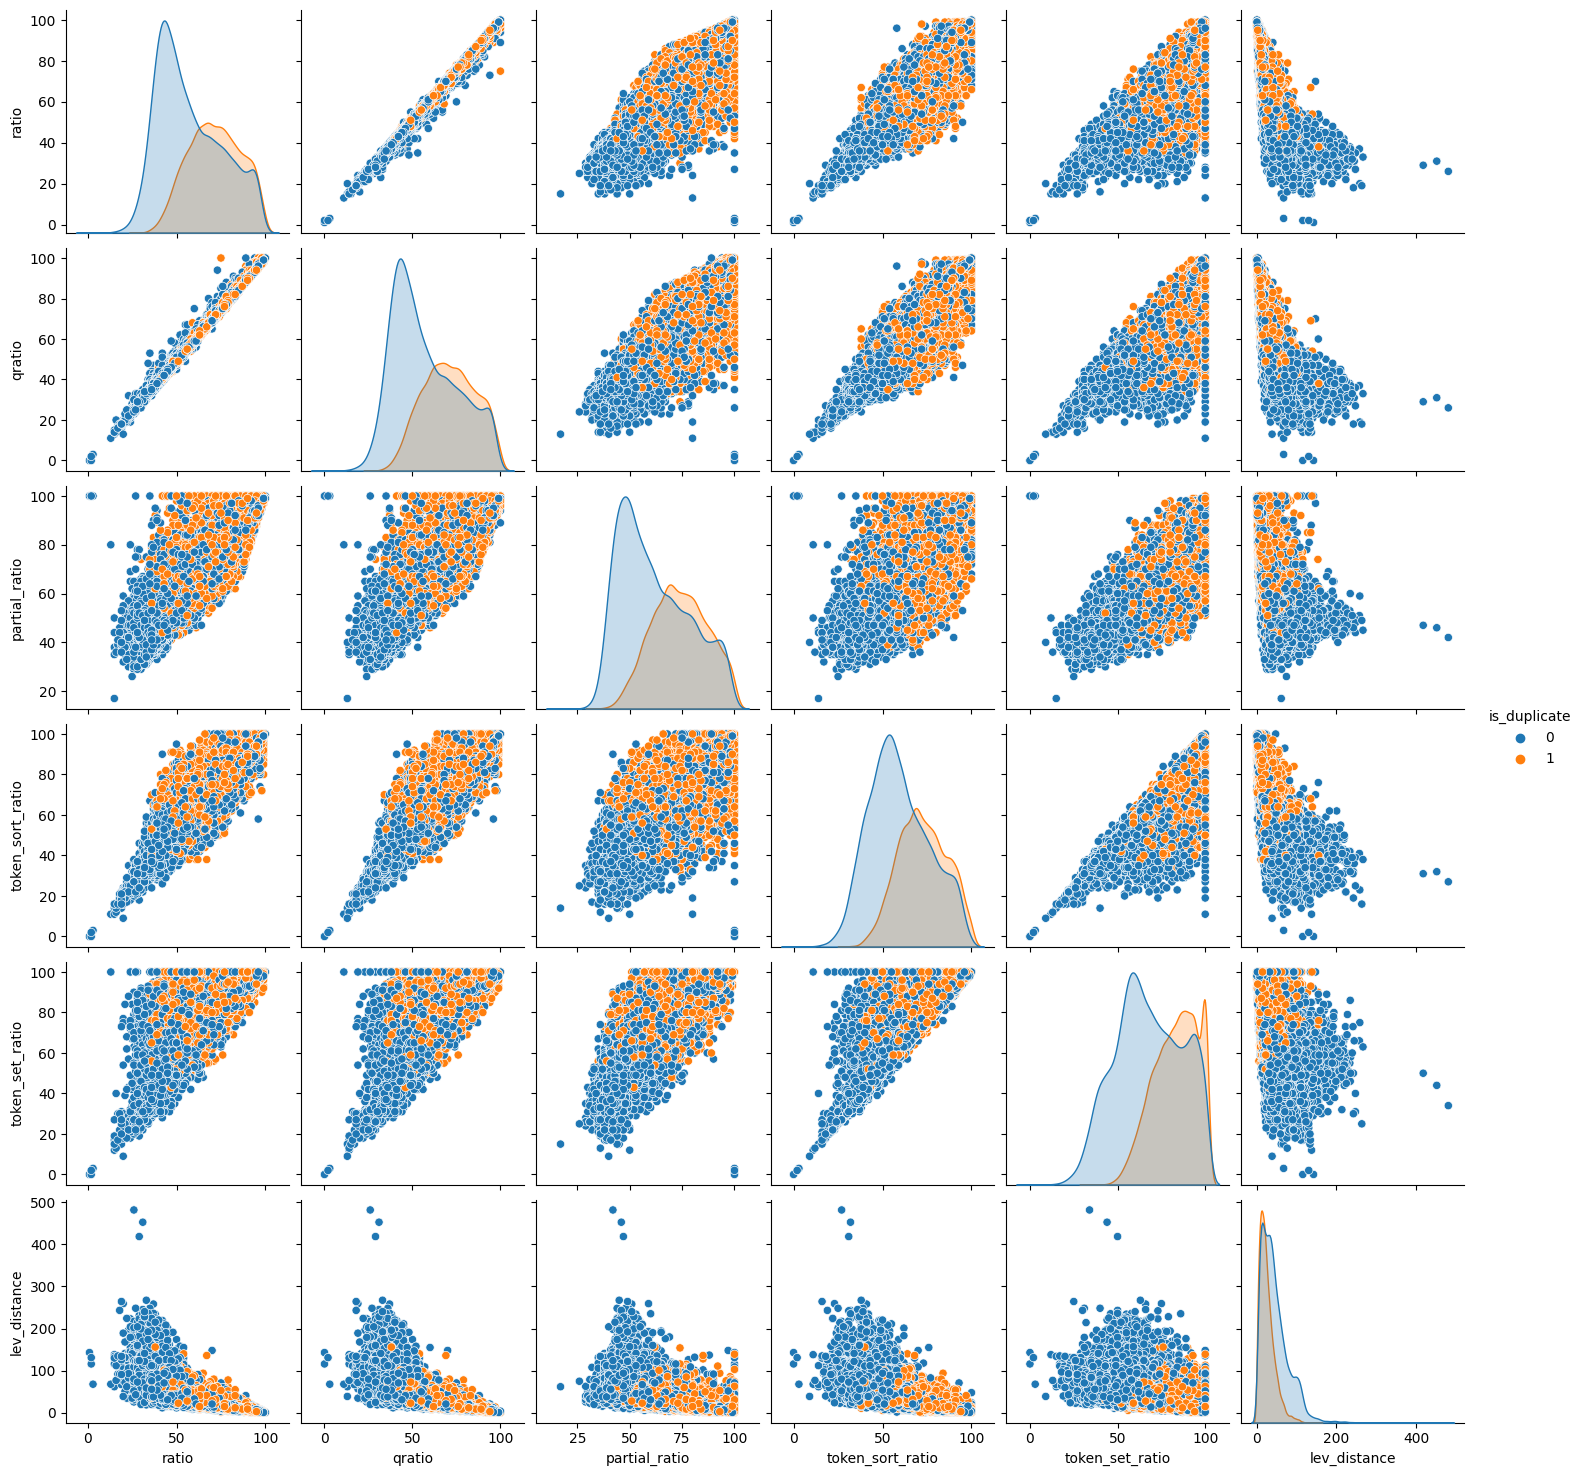

In [23]:
columns=['ratio','qratio','partial_ratio','is_duplicate','token_sort_ratio','token_set_ratio','lev_distance']
sns.pairplot(data=df_train[columns],hue='is_duplicate')

(1.0, 200.0)

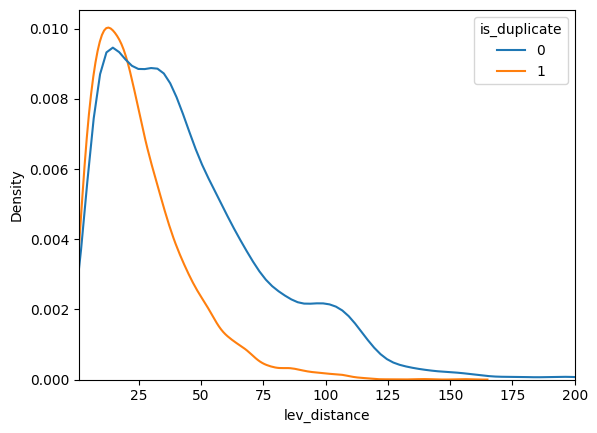

In [24]:
sns.kdeplot(data=df_train,x='lev_distance',hue='is_duplicate')
plt.xlim(min(df_train['lev_distance']),200)

In [25]:
columns_fs2=['ratio','qratio','partial_ratio','token_sort_ratio','token_set_ratio','lev_distance']
temp_df_bow=pd.concat([temp_df_bow,df_train[columns_fs2]],axis=1)
temp_df_idf=pd.concat([temp_df_idf,df_train[columns_fs2]],axis=1)
X_bow_train,X_bow_test,y_bow_train,y_bow_test=train_test_split(temp_df_bow,y,test_size=0.2)
X_idf_train,X_idf_test,y_idf_train,y_idf_test=train_test_split(temp_df_idf,y,test_size=0.2)
X_bow_train.columns = X_bow_train.columns.astype(str)
X_bow_test.columns = X_bow_test.columns.astype(str)
X_idf_train.columns = X_bow_train.columns.astype(str)
X_idf_test.columns = X_bow_test.columns.astype(str)


In [26]:

print("Extra Trees Results with fs2:")
print(evaluate_classifiers(ExtraTreesClassifier(),X_bow_train,y_bow_train,X_bow_test,y_bow_test))
print(evaluate_classifiers(ExtraTreesClassifier(),X_idf_train,y_idf_train,X_idf_test,y_idf_test))


Extra Trees Results with fs2:
(0.7748333333333334, 8.115829288116213)
(0.7848333333333334, 7.755392754225041)


In [27]:

print("Random Forest Results with fs2:")
print(evaluate_classifiers(RandomForestClassifier(),X_bow_train,y_bow_train,X_bow_test,y_bow_test))
print(evaluate_classifiers(RandomForestClassifier(),X_idf_train,y_idf_train,X_idf_test,y_idf_test))


Random Forest Results with fs2:
(0.7701666666666667, 8.284033003932093)
(0.774, 8.145865665940477)


In [28]:

print("AdaBoost Results with fs2:")
print(evaluate_classifiers(AdaBoostClassifier(),X_bow_train,y_bow_train,X_bow_test,y_bow_test))
print(evaluate_classifiers(AdaBoostClassifier(),X_idf_train,y_idf_train,X_idf_test,y_idf_test))


AdaBoost Results with fs2:
(0.7075, 10.542768616316767)
(0.7156666666666667, 10.248412113638977)


 # Text Pre-Processing and Implementation of Deep Learning

In [29]:
import re
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [30]:
df_train['question1'] = df_train['question1'].apply(preprocess)
df_train['question2'] = df_train['question2'].apply(preprocess)

In [31]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,w1_tokens,w2_tokens,w1_tot,w2_tot,common_words,word_share,ratio,qratio,partial_ratio,token_sort_ratio,token_set_ratio,lev_distance
349712,349712,478402,478403,can a hermaphrodite reproduce,how do snakes reproduce,0,30,24,"[can, a, hermaphrodite, reproduce, ?]","[how, do, snakes, reproduce, ?]",5,5,2,20.000000,56,54,64,50,56,17
33239,33239,61098,61099,what is the difference between structural and ...,how do i split my predictive model data,0,89,40,"[what, is, the, difference, between, structura...","[how, do, i, split, my, predictive, model, dat...",14,9,2,8.695652,33,31,40,39,41,70
167131,167131,143274,69241,how much do the stars of naked and afraid get ...,how much do contestants on naked and afraid ge...,1,58,53,"[how, much, do, the, stars, of, naked, and, af...","[how, much, do, contestants, on, naked, and, a...",14,11,9,36.000000,85,84,87,72,83,15
386298,386298,518494,518495,for people who wake up at 5 am or earlier wha...,is it better to wake up naturally after 4 5 ho...,0,82,114,"[for, people, who, wake, up, at, 5, am, or, ea...","[is, it, better, to, wake, up, naturally, afte...",20,26,8,17.391304,43,43,50,53,60,78
278697,278697,398013,18258,how do i remove paint stains from cloths,how do you remove blood stains from clothing,0,41,45,"[how, do, i, remove, paint, stains, from, clot...","[how, do, you, remove, blood, stains, from, cl...",9,9,6,33.333333,79,79,80,74,79,11


In [32]:
from gensim.models import Word2Vec
questions = list(df_train['question1']) + list(df_train['question2'])
model=Word2Vec(sentences=questions,vector_size=300,window=5)


In [33]:
def word_vector(tokens_list,model):
    if len(tokens_list) < 1:
        return np.zeros(300)
    vector = np.mean([model.wv[token] for token in tokens_list if token in model.wv] or [np.zeros(vector_size)], axis=0)
    return vector
    


In [34]:

df_train['q1_vec'] = df_train['question1'].apply(lambda x: word_vector(x, model))
df_train['q2_vec'] = df_train['question2'].apply(lambda x: word_vector(x, model))

In [35]:
df_train['q1_vec'].iloc[0].shape

(300,)

In [36]:
df_train=fuzzy_features(df_train)

In [37]:
df_train=fs_1(df_train)

In [38]:
from scipy.spatial.distance import braycurtis 
bray=[]
for i in range(len(df_train)):
    distance=(braycurtis(df_train['q1_vec'].iloc[i].flatten(),df_train['q2_vec'].iloc[i].flatten()))
    bray.append(distance)

In [39]:
df_train['bray_distance']=bray

(0.0, 0.2)

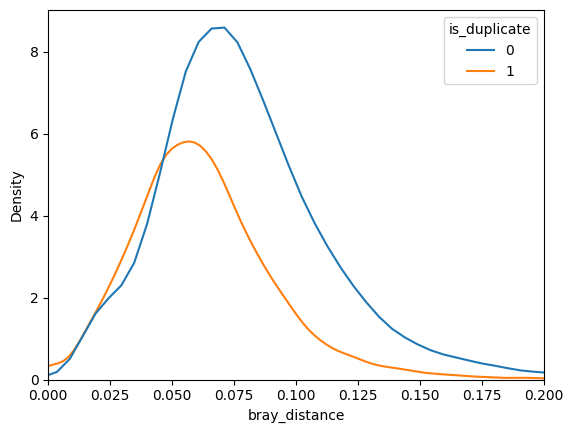

In [40]:
import seaborn as sns
sns.kdeplot(data=df_train,x='bray_distance',hue='is_duplicate')
plt.xlim(0,0.2)

In [41]:
from scipy.spatial.distance import cityblock
manhattan=[]
for i in range(len(df_train)):
    distance=(cityblock(df_train['q1_vec'].iloc[i].flatten(),df_train['q2_vec'].iloc[i].flatten()))
    manhattan.append(distance)


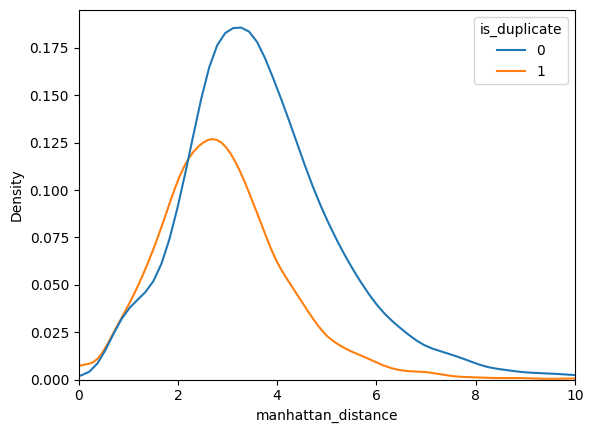

In [42]:
df_train['manhattan_distance']=manhattan
sns.kdeplot(data=df_train,x='manhattan_distance',hue='is_duplicate')
plt.xlim(0,10)
df_train['manhattan_distance']=manhattan

In [43]:
jaccard=[]
for i in range(len(df_train)):
    set1=set(df_train['w1_tokens'].iloc[i])
    set2=set(df_train['w2_tokens'].iloc[i])
    intersection=len(set1.intersection(set2))
    union=len(set1.union(set2))
    jaccard.append(intersection/union)
    

<Axes: xlabel='jaccard_similarity', ylabel='Density'>

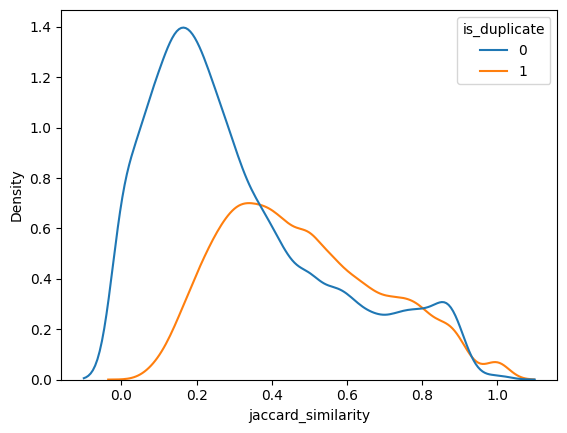

In [44]:
df_train['jaccard_similarity']=jaccard
sns.kdeplot(data=df_train,x='jaccard_similarity',hue='is_duplicate')

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
cosine=[]
for i in range(len(df_train)):
    similarity=cosine_similarity(df_train['q1_vec'].iloc[i].reshape(1,-1),df_train['q2_vec'].iloc[i].reshape(1,-1))
    cosine.append(similarity)


In [46]:
cosine_similarity=[]
for i in range(len(cosine)):
    cosine_similarity.append(cosine[i][0][0])


(0.8, 1.0)

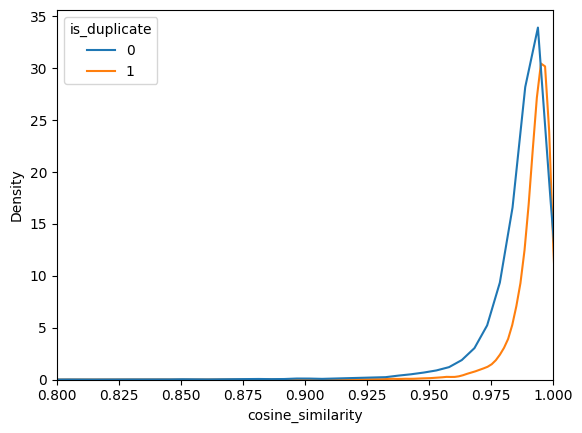

In [47]:
df_train['cosine_similarity']=cosine_similarity
sns.kdeplot(data=df_train,x='cosine_similarity',hue='is_duplicate')
plt.xlim(0.8,1.0)


In [48]:
df_train.drop(columns=['cosine_similarity'],inplace=True)

In [49]:
df_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'w1_tokens', 'w2_tokens', 'w1_tot', 'w2_tot',
       'common_words', 'word_share', 'ratio', 'qratio', 'partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'lev_distance', 'q1_vec',
       'q2_vec', 'bray_distance', 'manhattan_distance', 'jaccard_similarity'],
      dtype='object')

In [50]:
columns=['q1_vec', 'q2_vec', 'ratio', 'qratio', 'partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'lev_distance', 'q1_len',
       'q2_len', 'w1_tot', 'w2_tot', 'common_words',
       'word_share', 'bray_distance', 'manhattan_distance',
       'jaccard_similarity']
X=df_train[columns]
y=df_train['is_duplicate']
X.columns = X.columns.astype(str)

In [51]:
filtered_col=['ratio', 'qratio', 'partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'lev_distance', 'q1_len',
       'q2_len', 'w1_tot', 'w2_tot', 'common_words',
       'word_share', 'bray_distance', 'manhattan_distance',
       'jaccard_similarity']
X1=X['q1_vec']
X2=X['q2_vec']
X3=X[filtered_col]

2024-07-02 15:51:41.808307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 15:51:41.808403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 15:51:41.944400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


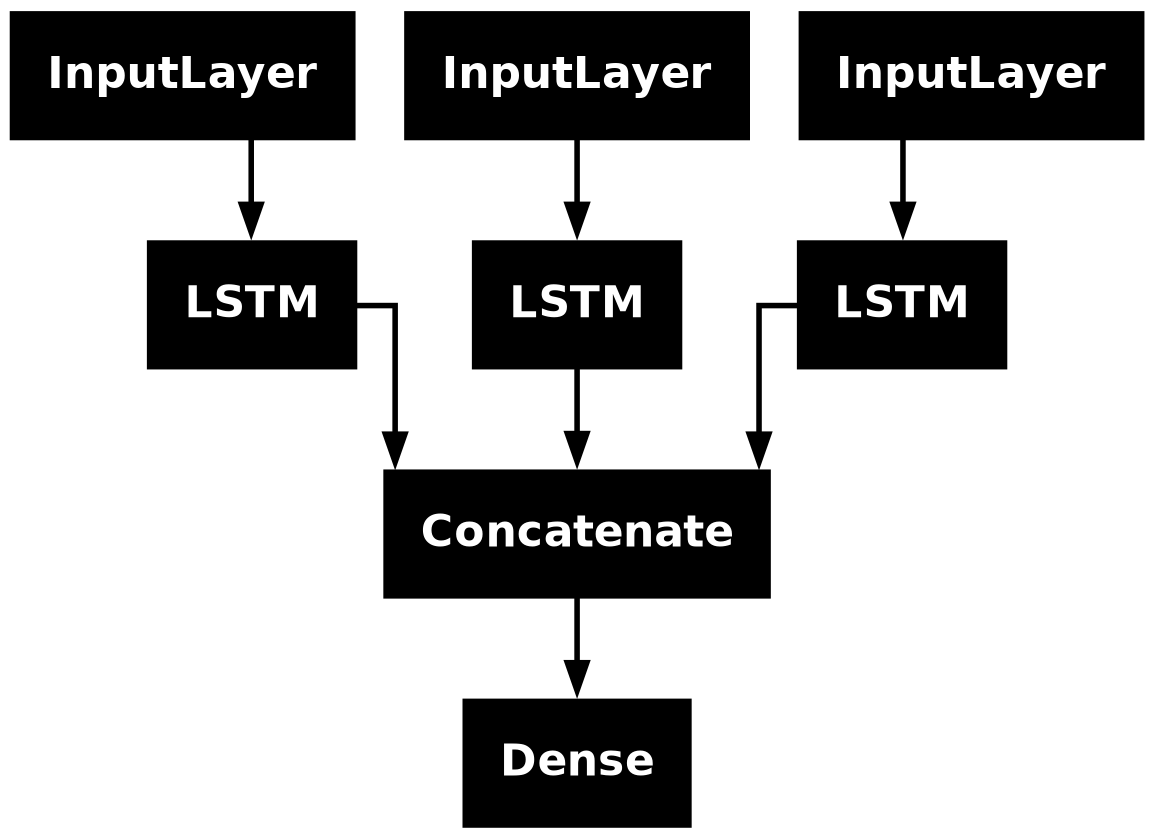

In [52]:
import keras
from tensorflow.keras.utils import plot_model
from keras.models import Model,Sequential
from keras.layers import LSTM,GRU,SimpleRNN,BatchNormalization,Dense,Dropout,Input,Concatenate
input1=Input(shape=(300,1))
input2=Input(shape=(300,1))
input3=Input(shape=(15,1))
lstm1=LSTM(150)(input1)
lstm2=LSTM(150)(input2)
lstm3=LSTM(150)(input3)
concatenate=Concatenate()([lstm1,lstm2,lstm3])
output=Dense(1)(concatenate)
model = Model(inputs=[input1,input2,input3], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
plot_model(model)

In [53]:
X1 = pd.DataFrame(X1.to_list())
X2 = pd.DataFrame(X2.to_list())

In [54]:

history=model.fit([X1, X2,X3],y, epochs=20)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.6275 - loss: 6.0045
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.6299 - loss: 5.9656
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6306 - loss: 5.9548
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6324 - loss: 5.9257
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6282 - loss: 5.9924
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.6354 - loss: 5.8774
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6296 - loss: 5.9709
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.6313 - loss: 5.9422
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.6279 - loss: 5.9979
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6310 - loss: 5.9472
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.6295 - loss: 5.9722
Epoch 12/20
938/938 ━━━━━━━━━━

In [55]:
y_pred=model.predict([X1,X2,X3])

938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


In [56]:
print("Log-Loss:",np.mean(history.history['loss']))

Log-Loss: 5.98196496963501


In [57]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,_=roc_curve(y,y_pred)
roc_auc=auc(fpr,tpr)

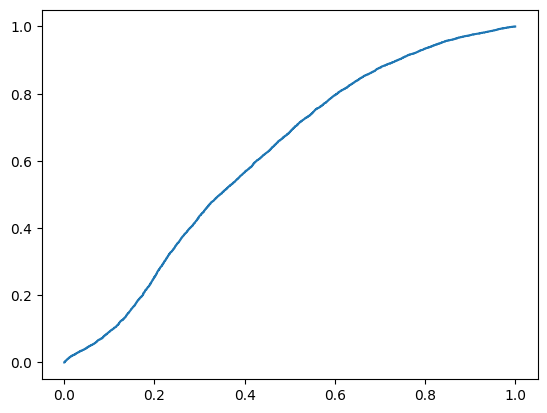

In [58]:
plt.plot(fpr, tpr)